In [2]:
import pandas as pd
from pathlib import Path
import re

In [3]:
data_dir = Path(r"C:\Users\ifesolom\Documents\GitHub\spring-2026-rat-activity-nyc\IRS folder") 

In [4]:
KEEP_BINS = {
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
}

def extract_zip_bracket_agi(excel_path, year=None, sheet_name=0):
    engine = "xlrd" if str(excel_path).lower().endswith(".xls") else "openpyxl"
    raw = pd.read_excel(excel_path, sheet_name=sheet_name, header=None, engine=engine)

    header_row = None
    for i in range(min(150, len(raw))):
        c0 = "" if pd.isna(raw.iloc[i, 0]) else str(raw.iloc[i, 0]).lower()
        c1 = "" if raw.shape[1] < 2 or pd.isna(raw.iloc[i, 1]) else str(raw.iloc[i, 1]).lower()
        if ("zip" in c0 and "code" in c0) and ("size of adjusted gross income" in c1):
            header_row = i
            break
    if header_row is None:
        raise ValueError(f"Header row not found in {excel_path}")

    agi_col = None
    for j in range(raw.shape[1]):
        cell = raw.iloc[header_row, j]
        if isinstance(cell, str) and ("adjusted gross income" in cell.lower()) and ("agi" in cell.lower()):
            agi_col = j
            break
    if agi_col is None:
        raise ValueError(f"AGI column not found in {excel_path}")
    
    data_start = header_row + 3

    df = raw.iloc[data_start:, [0, 1, agi_col]].copy()
    df.columns = ["ZIP code [1]", "Size of adjusted gross income", "Adjusted gross income (AGI)"]
    df = df.dropna(how="all")

    df["ZIP code [1]"] = df["ZIP code [1]"].astype(str).str.strip()
    df = df[df["ZIP code [1]"].str.match(r"^\d{5}$|^0$", na=False)].copy()

    df["Size of adjusted gross income"] = df["Size of adjusted gross income"].astype(str).str.strip()
    df = df[df["Size of adjusted gross income"].isin(KEEP_BINS)].copy()

    df["Adjusted gross income (AGI)"] = pd.to_numeric(df["Adjusted gross income (AGI)"], errors="coerce")

    if year is not None:
        df.insert(0, "Year", year)

    return df.reset_index(drop=True)

In [5]:

all_frames = []

for f in sorted(list(data_dir.glob("*.xls")) + list(data_dir.glob("*.xlsx"))):
    name = f.name.lower()

    try:
        yy = int(name[:2])
    except:
        print(f"Skipping (no leading year): {f.name}")
        continue

    if not (11 <= yy <= 22):
        continue
    year = 2000 + yy

    try:
        out = extract_zip_bracket_agi(f, year=year)
        all_frames.append(out)
        print(f"✓ {f.name}: {len(out):,} rows")
    except Exception as e:
        print(f"✗ {f.name}: {e}")

if all_frames:
    result = pd.concat(all_frames, ignore_index=True).sort_values(["Year", "ZIP code [1]", "Size of adjusted gross income"])
    result.to_csv(r"C:/Users/solom/Downloads/NY_files/NY_2011_2022_ZIP_bracket_AGI.csv", index=False)
    print("\nSaved: NY_2011_2022_ZIP_bracket_AGI.csv")
else:
    print("No valid data extracted.")

✓ 11zp33ny.xls: 9,288 rows
✓ 12zp33ny.xls: 9,282 rows
✓ 13zp33ny.xls: 9,252 rows
✓ 14zp33ny.xls: 9,264 rows
✓ 15zp33ny.xls: 9,240 rows
✓ 16zp33ny.xls: 9,246 rows
✓ 17zp33ny.xlsx: 9,222 rows
✓ 18zp33ny.xlsx: 9,216 rows
✓ 19zp33ny.xlsx: 9,210 rows
✓ 20zp33ny.xlsx: 9,234 rows
✓ 21zp33ny.xlsx: 9,216 rows
✓ 22zp33ny.xlsx: 9,222 rows

Saved: NY_2011_2022_ZIP_bracket_AGI.csv


In [6]:
result

,Year,ZIP code [1],Size of adjusted gross income,Adjusted gross income (AGI)
0,2011,0,"$1 under $25,000",44154659
4,2011,0,"$100,000 under $200,000",137909515
5,2011,0,"$200,000 or more",258179739
1,2011,0,"$25,000 under $50,000",77069038
2,2011,0,"$50,000 under $75,000",74962739
...,...,...,...,...
110890,2022,99999,"$100,000 under $200,000",1918767
110891,2022,99999,"$200,000 or more",18977340
110887,2022,99999,"$25,000 under $50,000",566215
110888,2022,99999,"$50,000 under $75,000",664620


In [1]:
## Loading and Cleaning Data for EDA 
import pandas as pd
import matplotlib.pyplot as plt
result = pd.read_csv(r"C:/Users/solom/Downloads/NY_files/NY_2011_2022_ZIP_bracket_AGI.csv")

# Clean data: Remove statewide aggregate (0) and invalid ZIP codes
original_shape = result.shape
result = result[result["ZIP code [1]"].astype(str).str.strip() != "0"]
result = result[result["ZIP code [1]"].astype(str).str.strip() != "99999"]
print(f"Data cleaning:")
print(f"  Original shape: {original_shape}")
print(f"  Cleaned shape: {result.shape}")
print(f"  Unique ZIP codes: {result['ZIP code [1]'].nunique()}")

Data cleaning:
  Original shape: (110892, 4)
  Cleaned shape: (110748, 4)
  Unique ZIP codes: 1553


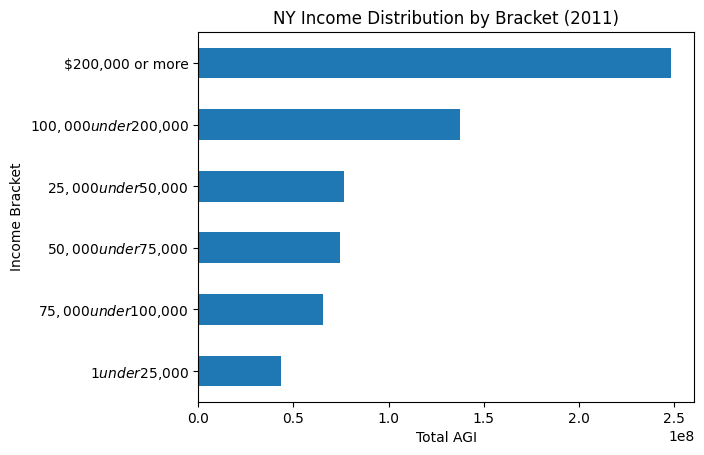

In [2]:
## Exploratory Data Analysis (EDA)

df = result.copy()

# Using 2011 as an example year to plot statewide distribution by bracket
year = 2011
df_year = df[df["Year"] == year]

# Sum AGI by bracket (statewide including 00000)
state = df_year.groupby("Size of adjusted gross income")["Adjusted gross income (AGI)"].sum()

plt.figure()
state.sort_values().plot(kind="barh")
plt.title(f"NY Income Distribution by Bracket ({year})")
plt.xlabel("Total AGI")
plt.ylabel("Income Bracket")
plt.show()

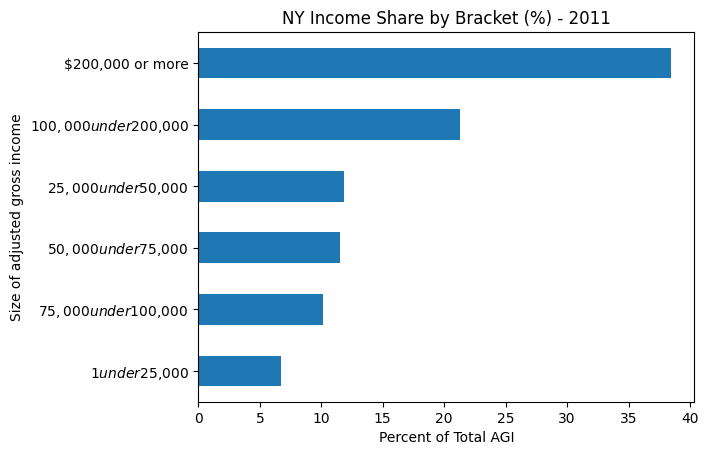

In [3]:
## Share of Income by Bracket (Statewide)
state_total = df_year["Adjusted gross income (AGI)"].sum()
share = (state / state_total) * 100


plt.figure()
share.sort_values().plot(kind="barh")
plt.title(f"NY Income Share by Bracket (%) - {year}")
plt.xlabel("Percent of Total AGI")
plt.show()

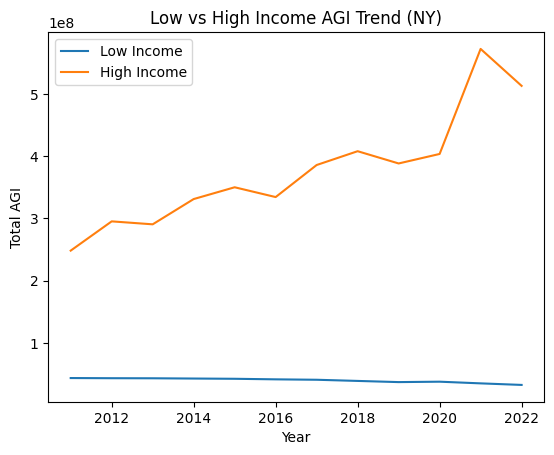

In [4]:
## Low income earner vs high income earner comparison (Statewide)
low = df[df["Size of adjusted gross income"] == "$1 under $25,000"]
high = df[df["Size of adjusted gross income"] == "$200,000 or more"]

low_trend = low.groupby("Year")["Adjusted gross income (AGI)"].sum()
high_trend = high.groupby("Year")["Adjusted gross income (AGI)"].sum()

plt.figure()
plt.plot(low_trend.index, low_trend.values)
plt.plot(high_trend.index, high_trend.values)
plt.title("Low vs High Income AGI Trend (NY)")
plt.xlabel("Year")
plt.ylabel("Total AGI")
plt.legend(["Low Income", "High Income"])
plt.show()

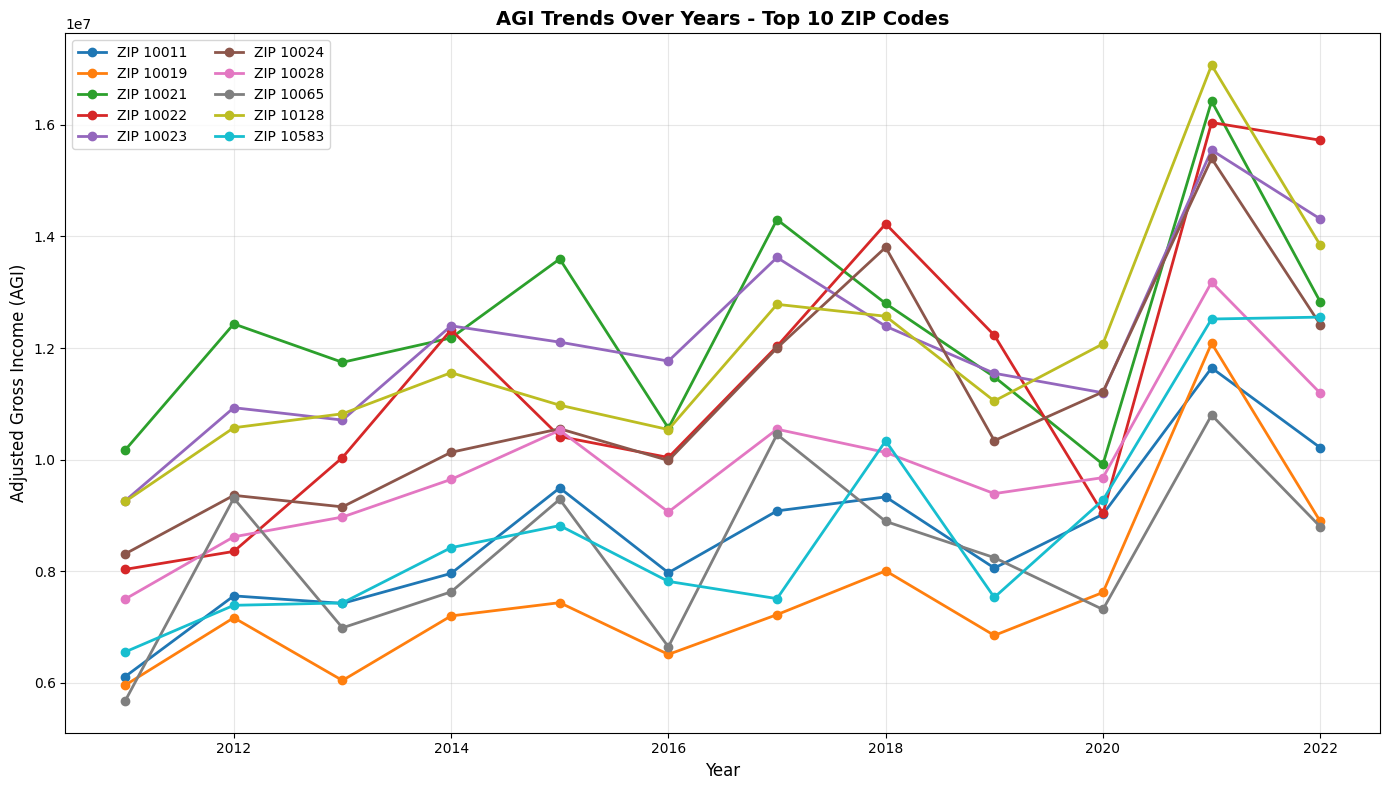

In [5]:
## Zone Code vs AGI Trend Over Years (Top 10 ZIP Codes)
top_zips_list = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

df_pivot = df[df["ZIP code [1]"].isin(top_zips_list)].groupby(
    ["Year", "ZIP code [1]"]
)["Adjusted gross income (AGI)"].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 8))

for zip_code in sorted(top_zips_list):
    zip_data = df_pivot[df_pivot["ZIP code [1]"] == zip_code].sort_values("Year")
    ax.plot(zip_data["Year"], zip_data["Adjusted gross income (AGI)"], marker='o', label=f"ZIP {zip_code}", linewidth=2)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Adjusted Gross Income (AGI)", fontsize=12)
ax.set_title("AGI Trends Over Years - Top 10 ZIP Codes", fontsize=14, fontweight='bold')
ax.legend(loc='best', ncol=2, fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


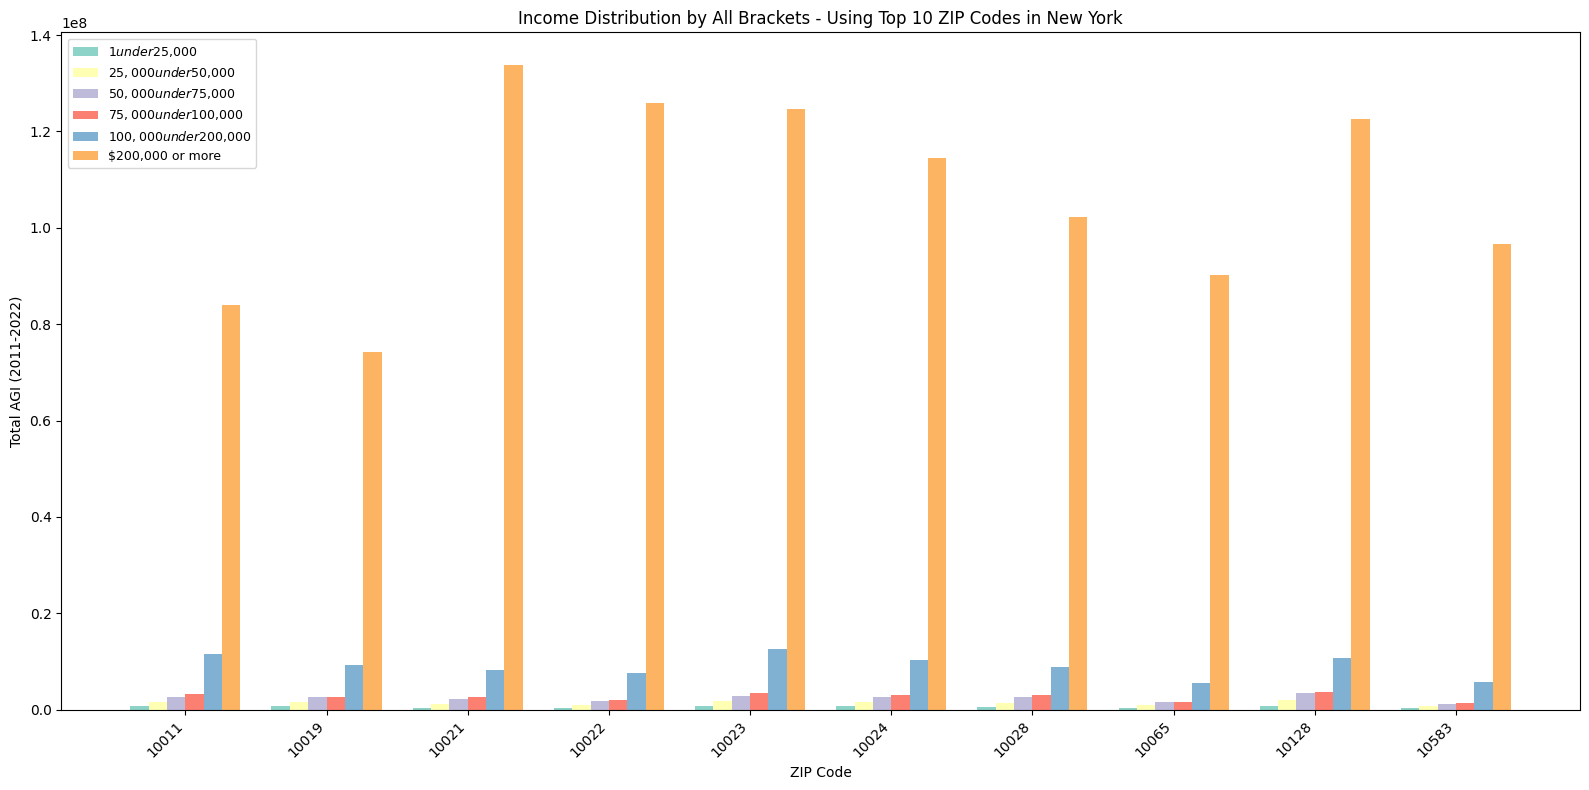

In [6]:
## Low vs High Income by All Brackets - Side by Side for Top ZIP Codes
top_zips_overall = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

pivot_data = df[df["ZIP code [1]"].isin(top_zips_overall)].groupby(
    ["ZIP code [1]", "Size of adjusted gross income"]
)["Adjusted gross income (AGI)"].sum().unstack(fill_value=0)

bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]
pivot_data = pivot_data[[col for col in bracket_order if col in pivot_data.columns]]

fig, ax = plt.subplots(figsize=(16, 8))
x = range(len(pivot_data))
width = 0.13 
colors = plt.cm.Set3(range(len(pivot_data.columns)))

for i, bracket in enumerate(pivot_data.columns):
    offset = (i - len(pivot_data.columns) / 2) * width + width / 2
    ax.bar([p + offset for p in x], pivot_data[bracket].values, width, label=bracket, color=colors[i])

ax.set_xlabel("ZIP Code")
ax.set_ylabel("Total AGI (2011-2022)")
ax.set_title("Income Distribution by All Brackets - Using Top 10 ZIP Codes in New York")
ax.set_xticks(x)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


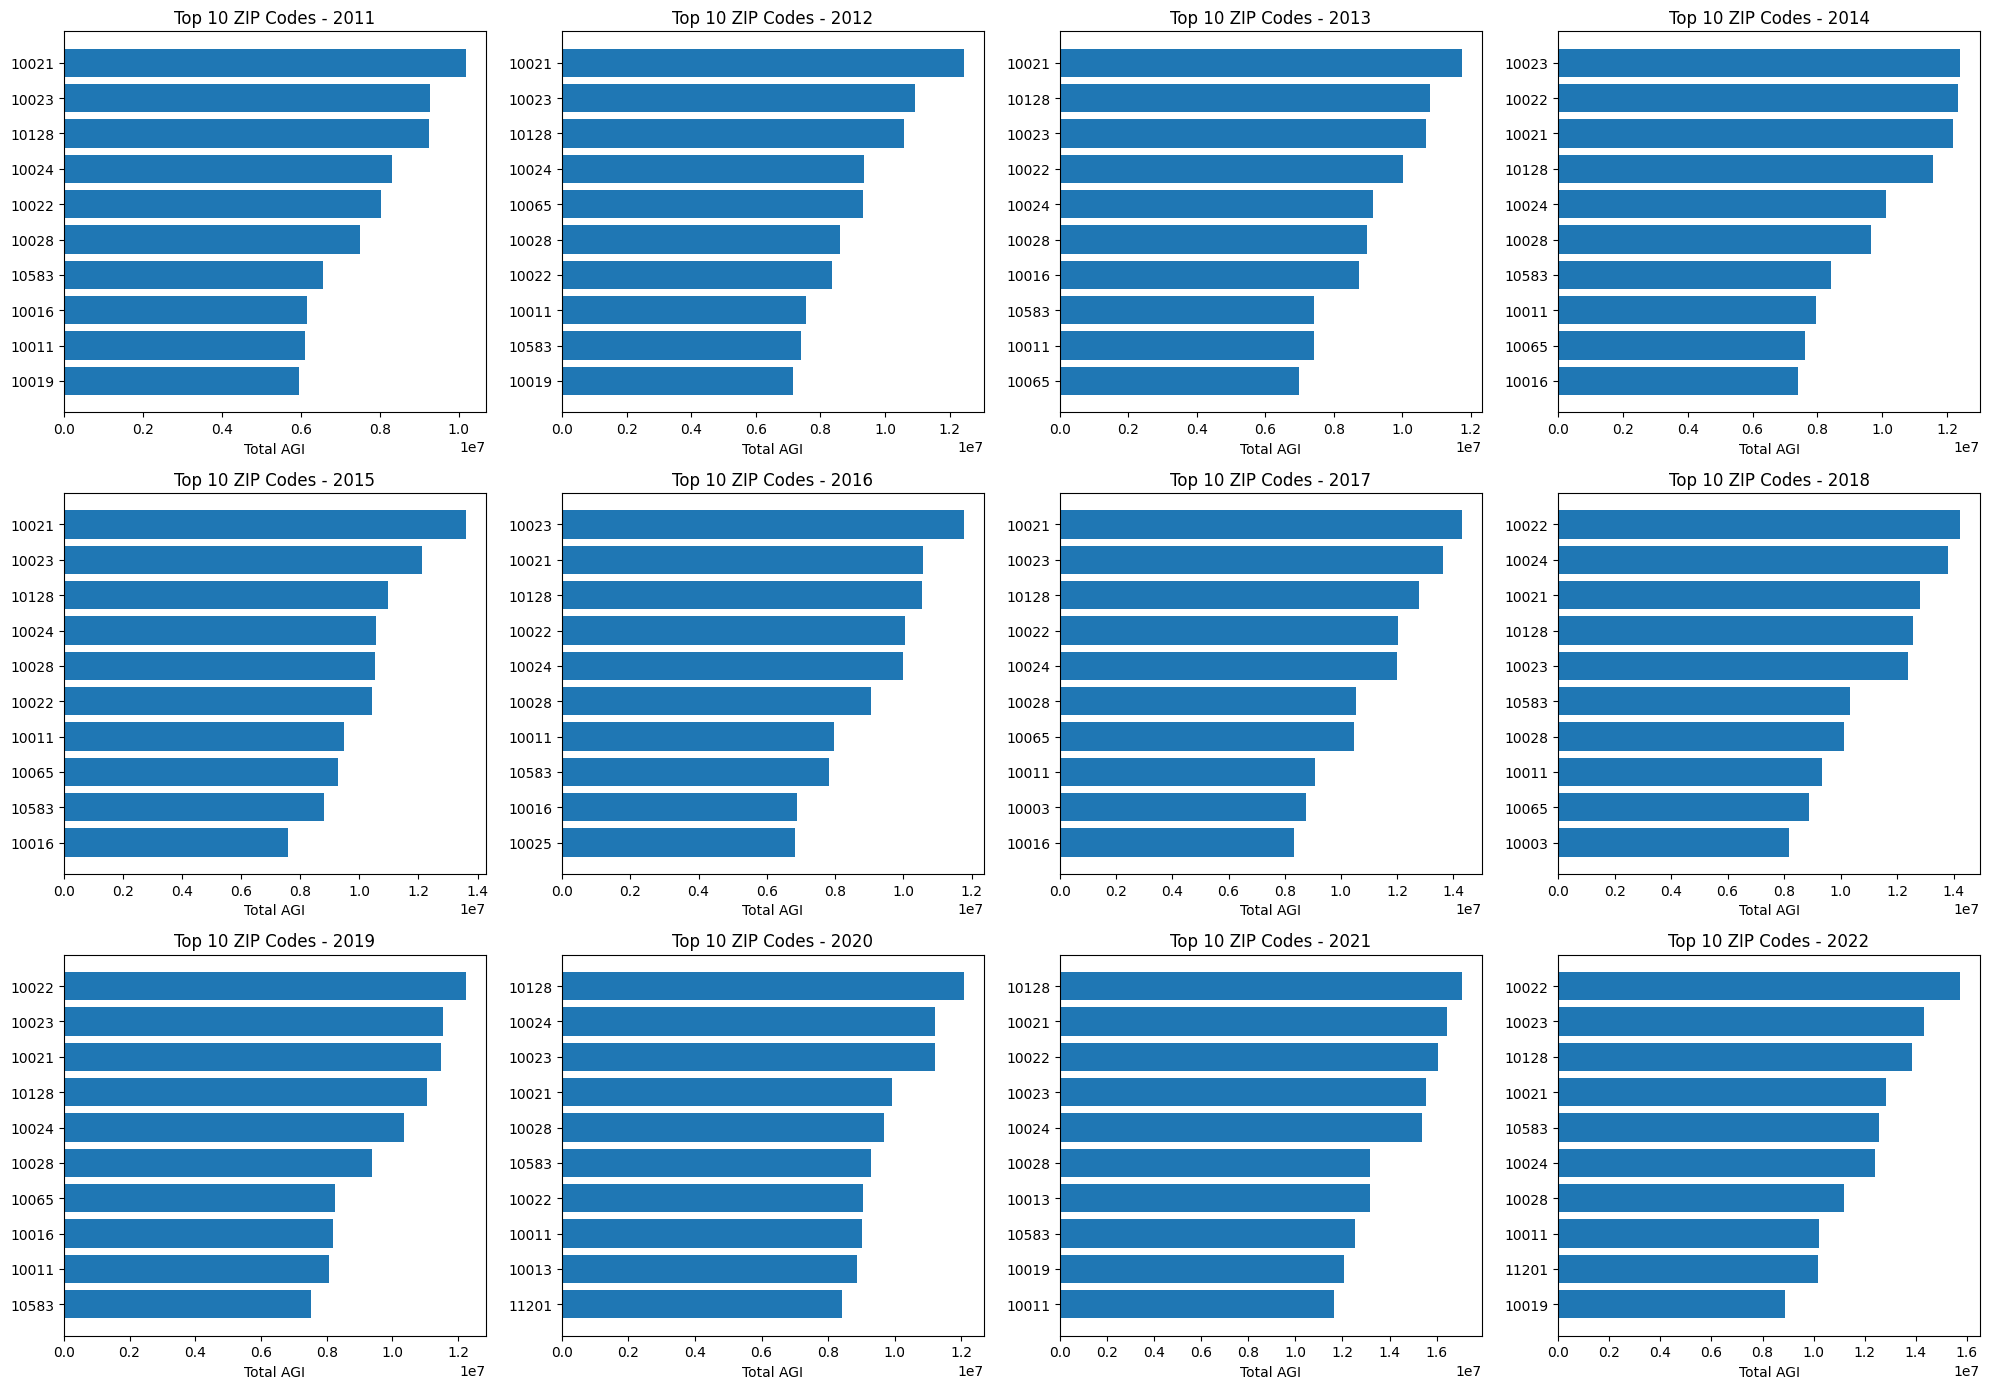

In [7]:
# Zone Code (ZIP) vs AGI - Side by Side by Year
years = sorted(df['Year'].unique())
n_years = len(years)
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for idx, year in enumerate(years):
    df_year = df[df['Year'] == year]
    zip_agi_year = df_year.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().sort_values(ascending=False)
    top_zips = zip_agi_year.head(10)
    axes[idx].barh(range(len(top_zips)), top_zips.values)
    axes[idx].set_yticks(range(len(top_zips)))
    axes[idx].set_yticklabels(top_zips.index)
    axes[idx].set_xlabel("Total AGI")
    axes[idx].set_title(f"Top 10 ZIP Codes - {year}")
    axes[idx].invert_yaxis()

for idx in range(len(years), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
## ZIP Code to County/Region Mapping
def map_zip_to_county(zip_code):
    """Map NY ZIP codes to counties/regions"""
    try:
        zip_int = int(zip_code)
    except:
        return "Other"
    
    # NYC Boroughs
    if 10001 <= zip_int <= 10299:
        return "Manhattan"
    elif 11200 <= zip_int <= 11299:
        return "Brooklyn"
    elif 11350 <= zip_int <= 11435:
        return "Queens"
    elif 10450 <= zip_int <= 10475:
        return "Bronx"
    elif 10300 <= zip_int <= 10314:
        return "Staten Island"
    # Westchester County
    elif 10501 <= zip_int <= 10977:
        return "Westchester"
    # Nassau County (Long Island)
    elif 11501 <= zip_int <= 11589:
        return "Nassau"
    # Suffolk County (Long Island)
    elif 11700 <= zip_int <= 11976:
        return "Suffolk"
    # Rockland County
    elif 10901 <= zip_int <= 10989:
        return "Rockland"
    # Orange County
    elif 10910 <= zip_int <= 10989:
        return "Orange"
    # Dutchess County
    elif 12514 <= zip_int <= 12601:
        return "Dutchess"
    else:
        return "Other"

# Adding the county column to dataframe
df_county = df.copy()
df_county["County"] = df_county["ZIP code [1]"].apply(map_zip_to_county)

# Getting major counties
major_counties = df_county[df_county["County"] != "Other"].groupby("County")["Adjusted gross income (AGI)"].sum().nlargest(6).index

print("Major Counties in Data:")
print(df_county[df_county["County"] != "Other"].groupby("County")["Adjusted gross income (AGI)"].sum().sort_values(ascending=False))


Major Counties in Data:
County
Manhattan        2264389519
Westchester      1186885610
Suffolk          1145311065
Brooklyn          902834858
Queens            579920817
Nassau            462518354
Bronx             305691327
Dutchess          199995987
Staten Island     193401630
Rockland           23616901
Name: Adjusted gross income (AGI), dtype: int64


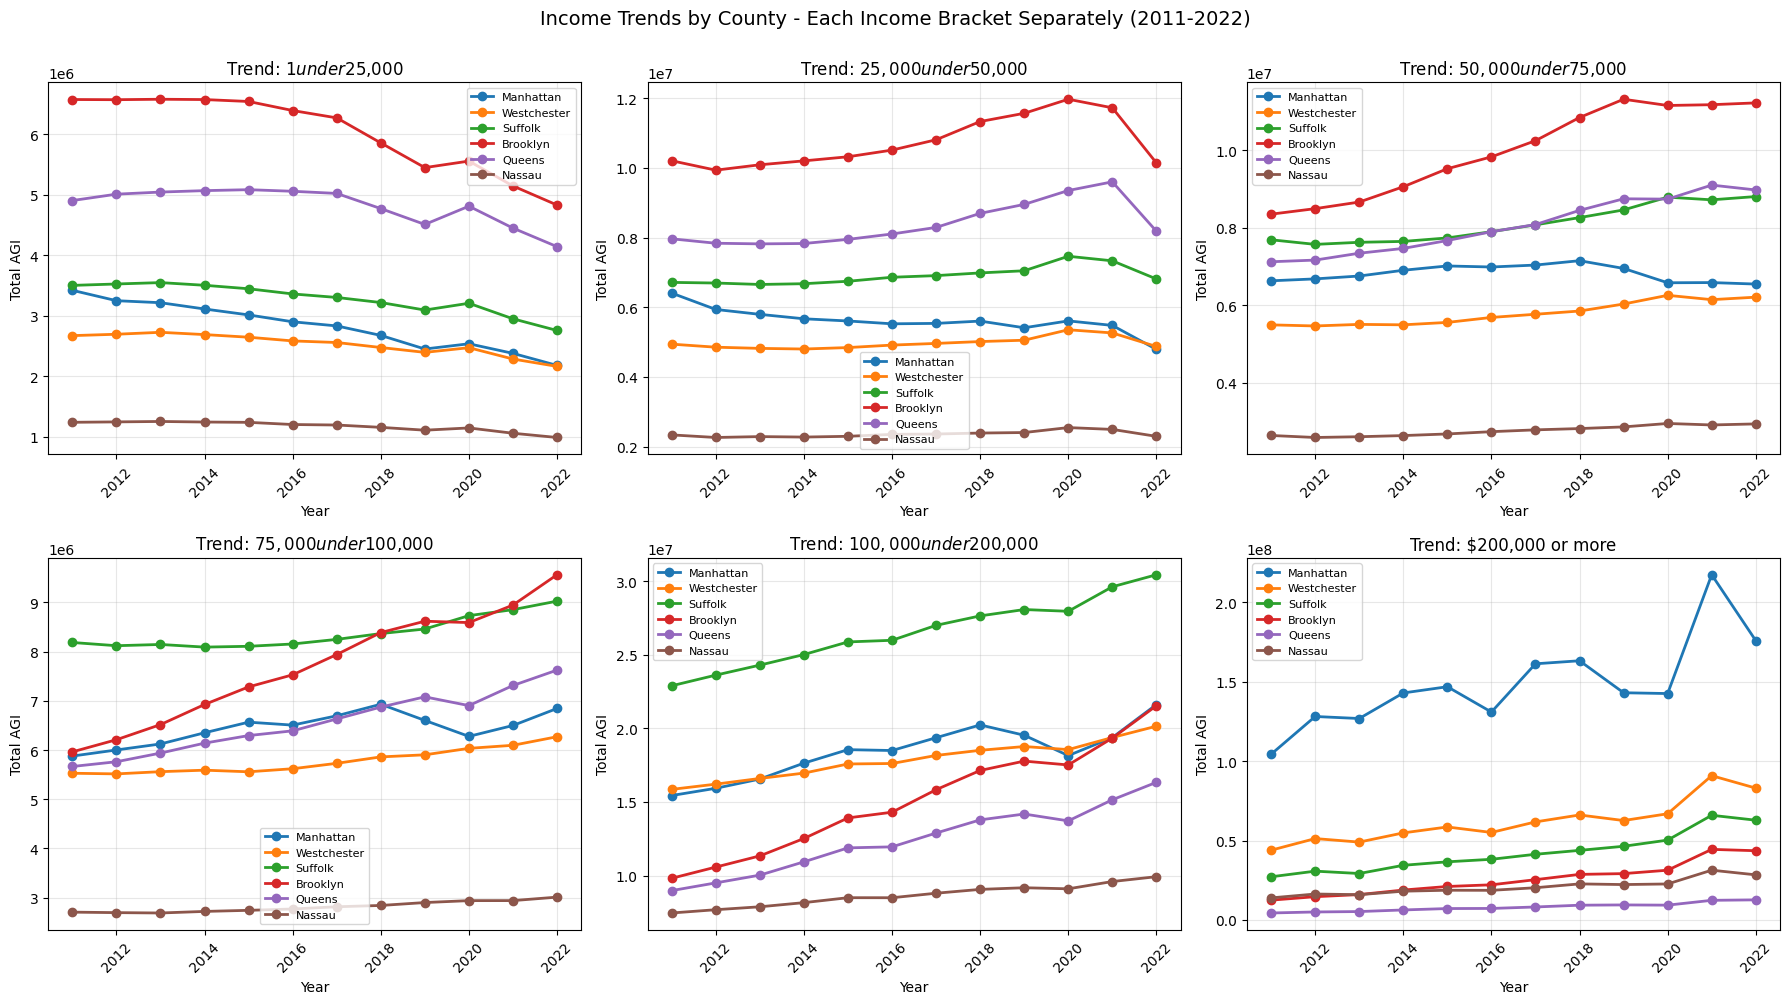

In [ ]:
## Income Bracket Trends by County (All Brackets)
bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

# Creating subplots for each income bracket
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = plt.cm.tab10(range(len(major_counties)))

for idx, bracket in enumerate(bracket_order):
    ax = axes[idx]
    bracket_data = df_county[df_county["Size of adjusted gross income"] == bracket]
    
    for color_idx, county in enumerate(major_counties):
        county_data = bracket_data[bracket_data["County"] == county].groupby("Year")["Adjusted gross income (AGI)"].sum()
        if not county_data.empty:
            ax.plot(county_data.index, county_data.values, marker='o', label=county, color=colors[color_idx], linewidth=2)
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Total AGI")
    ax.set_title(f"Trend: {bracket}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Income Trends by County - Each Income Bracket Separately (2011-2022)", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


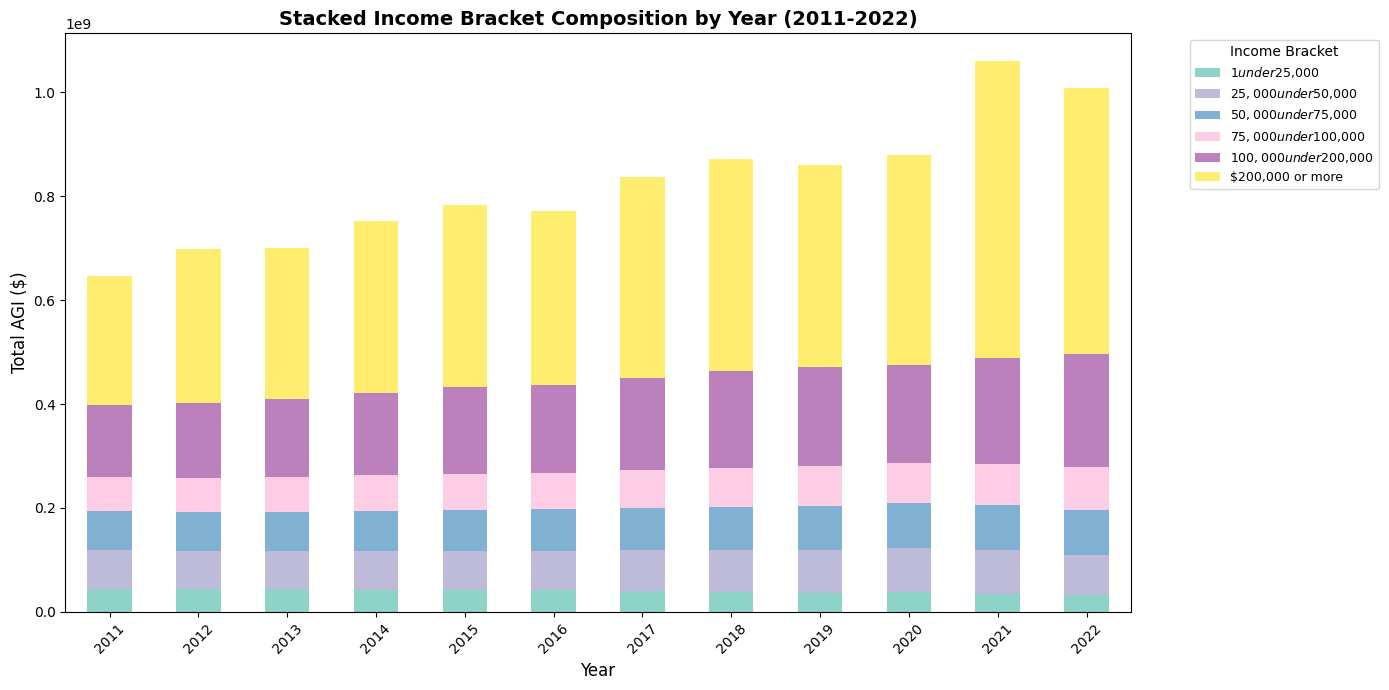

In [ ]:
## Income Bracket Composition by Year
bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

bracket_by_year = df.groupby(["Year", "Size of adjusted gross income"])["Adjusted gross income (AGI)"].sum().unstack(fill_value=0)
bracket_by_year = bracket_by_year[[col for col in bracket_order if col in bracket_by_year.columns]]

# stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
bracket_by_year.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total AGI ($)", fontsize=12)
ax.set_title("Stacked Income Bracket Composition by Year (2011-2022)", fontsize=14, fontweight='bold')
ax.legend(title="Income Bracket", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


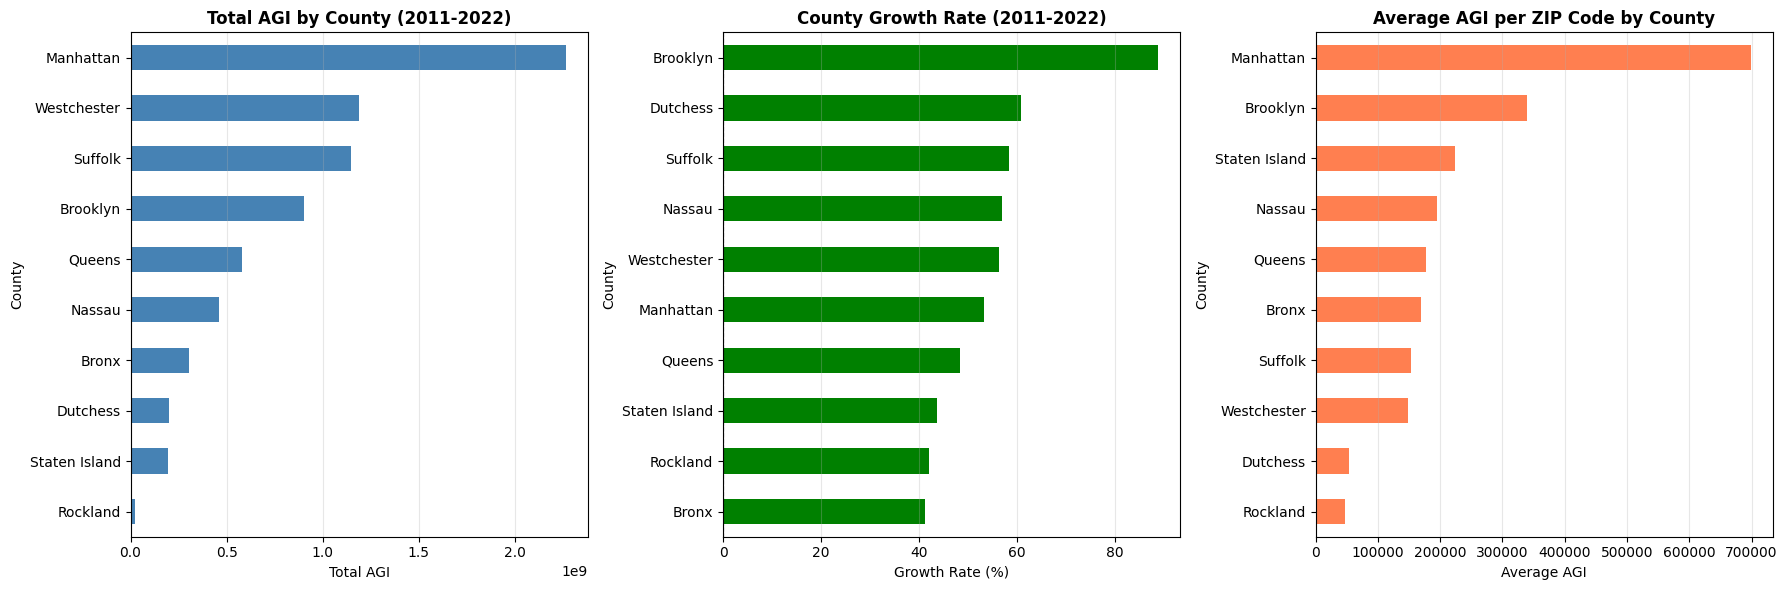


County Growth Summary (2011-2022):
  Bronx: +41.3%
  Rockland: +42.2%
  Staten Island: +43.7%
  Queens: +48.4%
  Manhattan: +53.3%
  Westchester: +56.4%
  Nassau: +57.1%
  Suffolk: +58.4%
  Dutchess: +60.8%
  Brooklyn: +89.0%


In [ ]:
## 3. County Comparison Charts
county_totals = df_county.groupby("County")["Adjusted gross income (AGI)"].sum().sort_values(ascending=True)
county_totals = county_totals[county_totals.index != "Other"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# County Totals
county_totals.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel("Total AGI")
axes[0].set_title("Total AGI by County (2011-2022)", fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# County Growth Rate (2011 vs 2022)
df_2011 = df_county[df_county["Year"] == 2011].groupby("County")["Adjusted gross income (AGI)"].sum()
df_2022 = df_county[df_county["Year"] == 2022].groupby("County")["Adjusted gross income (AGI)"].sum()
growth_rate = ((df_2022 - df_2011) / df_2011 * 100).sort_values(ascending=True)
growth_rate = growth_rate[growth_rate.index != "Other"]

colors = ['red' if x < 0 else 'green' for x in growth_rate]
growth_rate.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_xlabel("Growth Rate (%)")
axes[1].set_title("County Growth Rate (2011-2022)", fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Average AGI per County
avg_agi = df_county.groupby("County")["Adjusted gross income (AGI)"].mean().sort_values(ascending=True)
avg_agi = avg_agi[avg_agi.index != "Other"]

avg_agi.plot(kind='barh', ax=axes[2], color='coral')
axes[2].set_xlabel("Average AGI")
axes[2].set_title("Average AGI per ZIP Code by County", fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCounty Growth Summary (2011-2022):")
for county, rate in growth_rate.items():
    print(f"  {county}: {rate:+.1f}%")


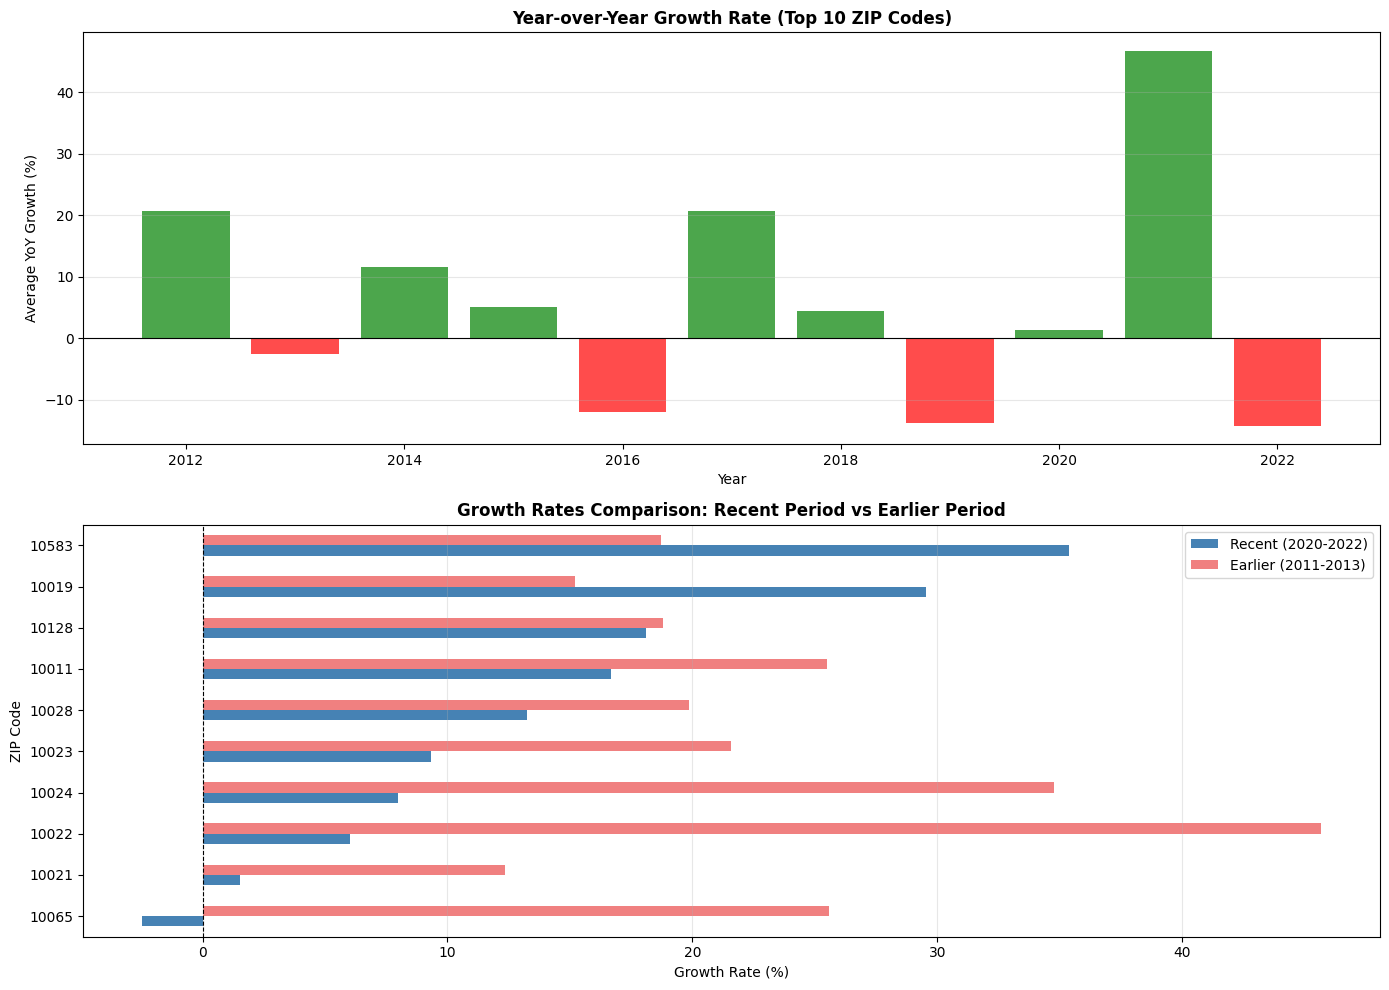

In [ ]:
## Year-over-Year Growth Rates
top_10_zips = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

yoy_growth = []
for year in sorted(df['Year'].unique())[1:]:
    prev_year = year - 1
    
    df_prev = df[df['Year'] == prev_year].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
    df_curr = df[df['Year'] == year].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
    
    growth = ((df_curr - df_prev) / df_prev * 100).fillna(0)
    yoy_growth.append({'Year': year, 'Growth_Rate': growth[growth.index.isin(top_10_zips)].mean()})

yoy_df = pd.DataFrame(yoy_growth)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# YoY Growth Rate Trend
colors = ['green' if x > 0 else 'red' for x in yoy_df['Growth_Rate']]
axes[0].bar(yoy_df['Year'], yoy_df['Growth_Rate'], color=colors, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Average YoY Growth (%)")
axes[0].set_title("Year-over-Year Growth Rate (Top 10 ZIP Codes)", fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Growth Rate by Top 10 ZIPs (Latest 3 Years vs Previous 3 Years)
recent_years = sorted(df['Year'].unique())[-3:]
earlier_years = sorted(df['Year'].unique())[-6:-3]

df_recent = df[df['Year'].isin(recent_years)].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
df_earlier = df[df['Year'].isin(earlier_years)].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()

growth_comparison = pd.DataFrame({
    'Recent (2020-2022)': ((df_recent - df_earlier) / df_earlier * 100).fillna(0),
    'Earlier (2017-2019)': 0
})

# Calculating the actual growth for earlier period
df_earliest = df[df['Year'].isin(sorted(df['Year'].unique())[:3])].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
growth_comparison['Earlier (2011-2013)'] = ((df_earlier - df_earliest) / df_earliest * 100).fillna(0)

growth_comparison = growth_comparison[growth_comparison.index.isin(top_10_zips)].sort_values('Recent (2020-2022)', ascending=True)

growth_comparison[['Recent (2020-2022)', 'Earlier (2011-2013)']].plot(kind='barh', ax=axes[1], color=['steelblue', 'lightcoral'])
axes[1].set_xlabel("Growth Rate (%)")
axes[1].set_ylabel("ZIP Code")
axes[1].set_title("Growth Rates Comparison: Recent Period vs Earlier Period", fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


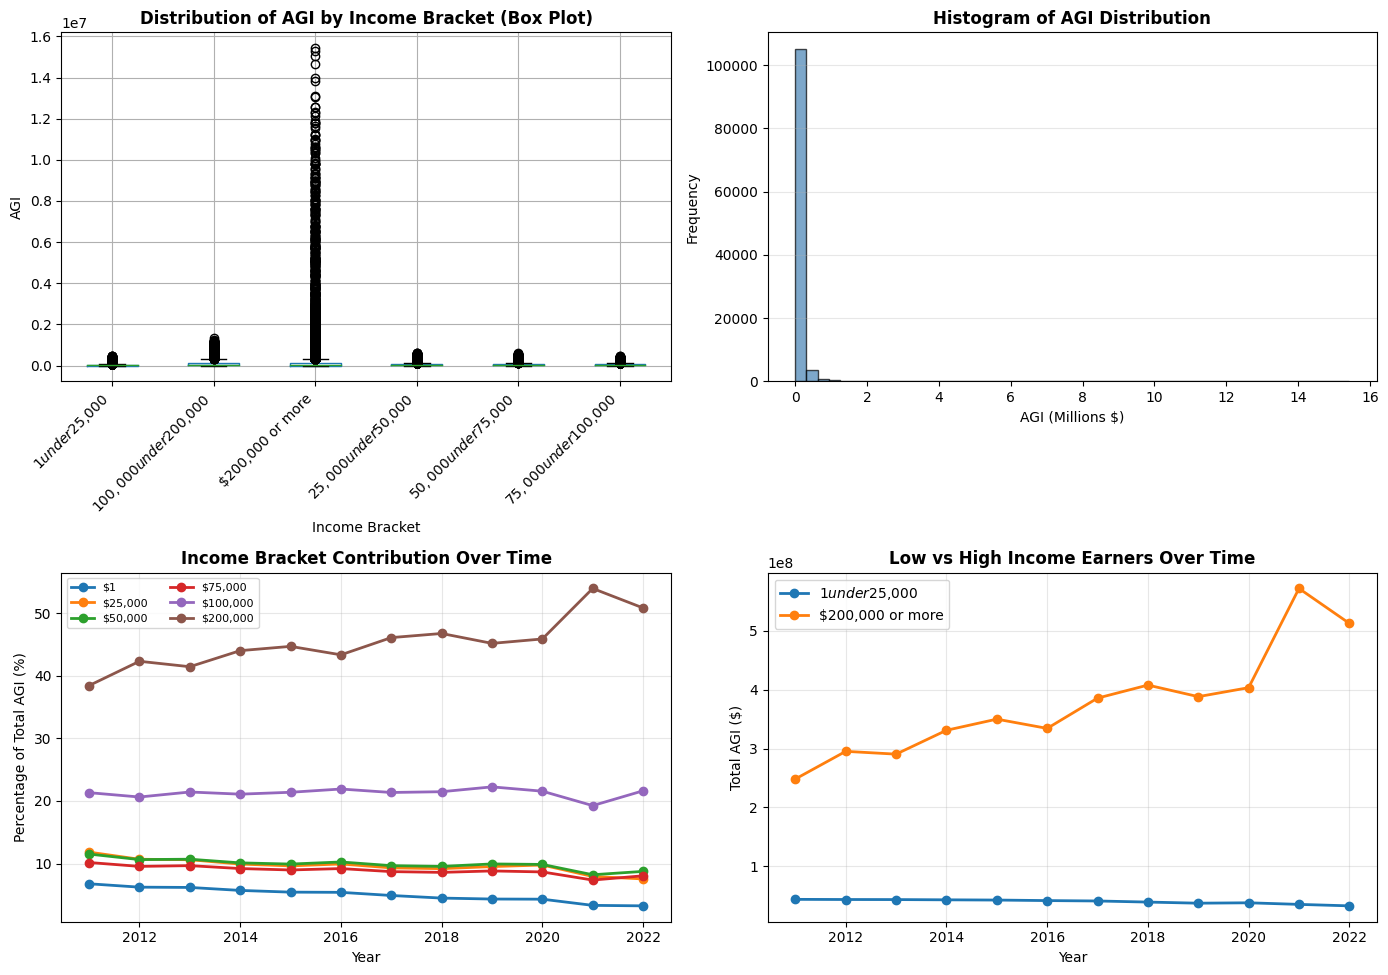

In [ ]:
## Distribution Plots - Income Bracket Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Box Plot of AGI by Income Bracket
df.boxplot(column='Adjusted gross income (AGI)', by='Size of adjusted gross income', ax=axes[0, 0])
axes[0, 0].set_xlabel("Income Bracket")
axes[0, 0].set_ylabel("AGI")
axes[0, 0].set_title("Distribution of AGI by Income Bracket (Box Plot)", fontweight='bold')
fig.suptitle('')
plt.sca(axes[0, 0])
plt.xticks(rotation=45, ha='right')

# Histogram of AGI values
axes[0, 1].hist(df['Adjusted gross income (AGI)'] / 1e6, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel("AGI (Millions $)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Histogram of AGI Distribution", fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Bracket contribution percentage over time
bracket_pct = df.groupby(['Year', 'Size of adjusted gross income'])['Adjusted gross income (AGI)'].sum().unstack(fill_value=0)
bracket_pct_normalized = bracket_pct.div(bracket_pct.sum(axis=1), axis=0) * 100

bracket_list = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

for bracket in bracket_list:
    if bracket in bracket_pct_normalized.columns:
        axes[1, 0].plot(bracket_pct_normalized.index, bracket_pct_normalized[bracket], marker='o', label=bracket.split()[0], linewidth=2)

axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Percentage of Total AGI (%)")
axes[1, 0].set_title("Income Bracket Contribution Over Time", fontweight='bold')
axes[1, 0].legend(fontsize=8, loc='best', ncol=2)
axes[1, 0].grid(True, alpha=0.3)

# Top brackets trend
top_brackets = ['$1 under $25,000', '$200,000 or more']
for bracket in top_brackets:
    bracket_trend = df[df['Size of adjusted gross income'] == bracket].groupby('Year')['Adjusted gross income (AGI)'].sum()
    axes[1, 1].plot(bracket_trend.index, bracket_trend.values, marker='o', label=bracket, linewidth=2, markersize=6)

axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Total AGI ($)")
axes[1, 1].set_title("Low vs High Income Earners Over Time", fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
